In [1]:
%load_ext autoreload
%autoreload 2

# Device selection

In [2]:
from cobos.tokens import ibm_token, group_instance, group_instance2
from qiskit_ibm_runtime import QiskitRuntimeService

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"
device = "ibm_marrakesh"

first_layout_qubit = 61
eplg_absolute = 5e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance2)
backend = service.backend(device)

# Auxiliary lattice plot

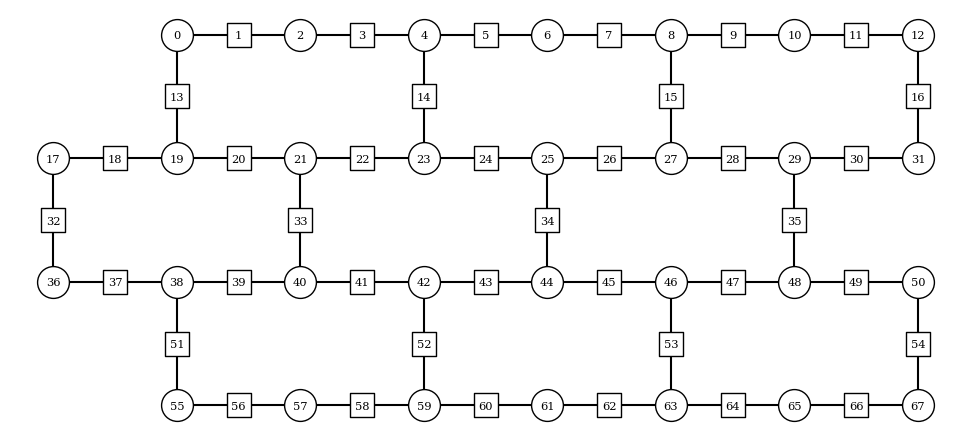

In [3]:
from z2hex.geometry import HeavyHexLattice

plaquette_width = 3
plaquette_height = 3

HeavyHexLattice(plaquette_width, plaquette_height).plot_lattice(number_qubits=True)

# Simulation settings

In [4]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

lattice_dims_arr = [(3, 3)]
J_arr = [1]
h_arr = [1]
lamb_arr = [0.5]
g_arr = [8]

x_basis = False

fractional_gates = False

# strings_arr = [[6, 7, 8, 16, 26, 25, 24, 34, 43, 44, 45, 54, 64, 63, 62, 72, 81, 82, 83, 92, 102, 101, 100]]
strings_arr = [[6, 5, 14, 24, 34, 43, 52, 60, 61]]

final_time = 8
steps = 35

max_layers = 200

shots = 75000

odr = True
flip_threshold = 3

sampler_options = {
    "default_shots": shots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

execution_database = "z2_hex_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Circuit generation & observables

In [ ]:
from z2hex.circs import erradj_string_quench_simulation_circuits_eplg, odr_compuncomp_circuits_eplg
from z2hex.operators import local_pauli_x, local_pauli_z, postselection_operators
from utils.plotting import plot_circuit_arr_depth
from utils.circs import generate_and_save_circs
from z2hex.geometry import HeavyHexLattice
from functools import partial
from itertools import product
import os

optimization_level = 3

circuits = [] # circuits[dims][Jhλg][t]
if odr: odr_circuits = []
observable_generating_funcs = [] # observable_generating_funcs[dims][i]
postselection_operators_funcs = [] # postselection_operators_funcs[dims][i]
extra_options = [] # extra_options[dims][Jhλg]

for (px, py), string_arr in zip(lattice_dims_arr, strings_arr):
    this_circuits = []
    if odr: this_odr_circuits = []
    this_extra_options = []
    lattice = HeavyHexLattice(px, py)
    for J, h, lamb, g in product(J_arr, h_arr, lamb_arr, g_arr):
        circuits_filepath = os.path.join(circ_folder_path, f"z2hex_string_quench_circs_{device}_px_{px}_py_{py}_maxt_{final_time}_steps_{steps}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_fqb_{first_layout_qubit}_string_{"-".join([str(i) for i in string_arr])}_xbasis_{x_basis}.qpy")
        circs_args = (lattice, J, h, lamb, string_arr, final_time, steps, backend, optimization_level, eplg_absolute, g, first_layout_qubit, x_basis, False, max_layers)
        physical_circuits = erradj_string_quench_simulation_circuits_eplg(*circs_args)
        this_circuits.append(physical_circuits)
        this_extra_options.append({"backend": device, "plaquette_width": px, "plaquette_height": py, "J": J, "h": h, "λ":lamb, "g": g, "string_arr": string_arr, "final_time": final_time, "eplg": eplg_absolute} | ({"fractional_gates": True} if fractional_gates else {}))
        if odr:
            odr_func_args = (lattice, J, h, lamb, final_time, steps, backend, eplg_absolute, g, string_arr, first_layout_qubit, x_basis, False, max_layers)
            this_odr_circuits.append(odr_compuncomp_circuits_eplg(*odr_func_args))
    circuits.append(this_circuits)
    if odr: odr_circuits.append(this_odr_circuits)
    observable_generating_funcs.append([(lambda nqubits, i=i: local_pauli_x(lattice, i) if x_basis else local_pauli_z(lattice, i)) for i in range(len(lattice))])
    postselection_operators_funcs.append(lambda nqubits: postselection_operators(lattice, x_basis))
    extra_options.append(this_extra_options)

# circuits[0][0][1].draw(output="mpl", idle_wires=False)
plot_circuit_arr_depth(circuits[0][0])

# Post-selected circuit execution

### Send jobs to hardware

In [ ]:
from utils.postselection import execute_postselected_sampler_batch
from itertools import product

jobs = [] # jobs[dims][Jhλg][t]

for i, (px, py) in enumerate(lattice_dims_arr):
    this_dims_jobs = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        params_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
        if odr:
            this_jobs = execute_postselected_sampler_batch(backend, sampler_options, circuits[i][params_ind], postselection_operators_funcs[i], observable_generating_funcs[i], odr_circuits=odr_circuits[i][params_ind], extra_options=extra_options[i][params_ind], job_db=job_db)
        else:
            this_jobs = execute_postselected_sampler_batch(backend, sampler_options, circuits[i][params_ind], postselection_operators_funcs[i], observable_generating_funcs[i], extra_options=extra_options[i][params_ind], job_db=job_db)
        this_dims_jobs.append(this_jobs)
    jobs.append(this_dims_jobs)

### Load jobs with the same options

In [17]:
from utils.postselection import load_postselected_jobs
from itertools import product

observables = [] # jobs[dims][Jhλg][t]
samples_dicts = [] # samples_dicts[dims][Jhλg][t]
postselected_samples_dicts = [] # postselected_samples_dicts[dims][Jhλg][t]

for i, (px, py) in enumerate(lattice_dims_arr):
    this_dims_observables = []
    this_dims_samples_dicts = []
    this_dims_postselected_samples_dicts = []
    for j, (Ji, hi, lambi, gi) in enumerate(product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr)))):
        clean_extra_options = extra_options[i][j].copy()
        del clean_extra_options["eplg"]
        if odr:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, sampler_options, circuits[i][j], postselection_operators_funcs[i], observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True, odr_circuits=odr_circuits[i][j], max_shots=shots)
        else:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, sampler_options, circuits[i][j], postselection_operators_funcs[i], observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True, max_shots=shots)
        this_dims_observables.append(this_observables)
        this_dims_samples_dicts.append(this_samples_dicts)
        this_dims_postselected_samples_dicts.append(this_postselected_samples_dicts)
    observables.append(this_dims_observables)
    samples_dicts.append(this_dims_samples_dicts)
    postselected_samples_dicts.append(this_dims_postselected_samples_dicts)

/Users/cobos/MEGAsync/Doctorado/2nd year/IBM hardware execution/Repo/src/utils/odr.py:13: RuntimeWarning: divide by zero encountered in divide
  return (measured_observable_arr - p_arr*observable_trace/nqubits) / (1 - p_arr)


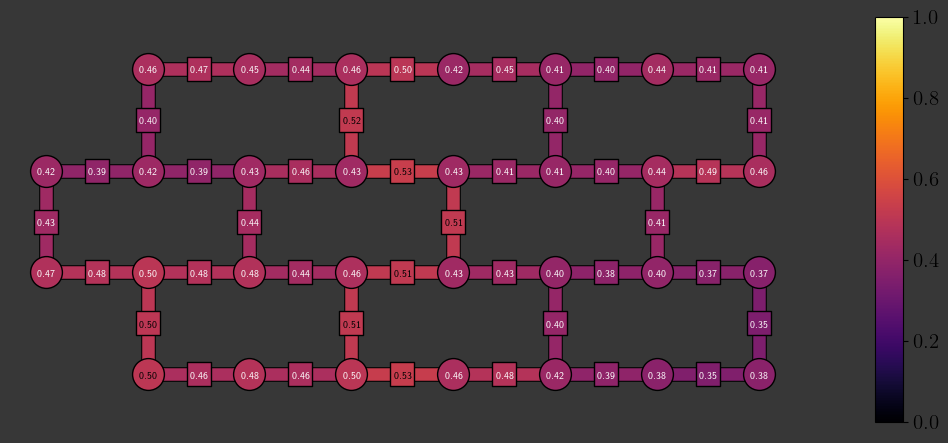

In [8]:
from utils.postselection import initialize_postselection, measure_diagonal_observables, get_recovered_postselected_samples_dict
from z2hex.plotting import local_observable_plot

job_index = 5

postselection_ops, diagonal_observables, non_diagonal_observables, basis = initialize_postselection(len(lattice), postselection_operators_funcs[i], observable_generating_funcs[i])

samples = samples_dicts[0][0][0][job_index]
psamples_manual = get_recovered_postselected_samples_dict(samples, postselection_ops, circuits[0][0][job_index].layout.final_index_layout()[::-1], flip_threshold=flip_threshold)
psamples = postselected_samples_dicts[0][0][0][job_index]
pobservables = measure_diagonal_observables(psamples_manual, diagonal_observables, circuits[0][0][job_index].layout.final_index_layout())[::-1]

local_observable_plot((1-observables[0][0][3][25])/2, lattice, cmap_range=[0, 1], dark_theme=True)

# Plots

In [20]:
from z2hex.plotting import local_obs_anim

interpolation_frames = 17
fps = 30
frame_to_title_func = lambda frame: f"$t = {final_time * frame / ((interpolation_frames+1)*steps):.02f}$"

for i, (px, py) in enumerate(lattice_dims_arr):
    for j, (Ji, Hi, lambi, gi) in enumerate(product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr)))):
        this_occupations = (1 - observables[i][j][3])/2
        local_obs_anim(this_occupations, lattice, frame_to_title_func, interpolation_frames=interpolation_frames, fps=fps, cmap_range=[0, 1], dark_theme=True, filepath=f"z2hex_nodr_string_quench_{device}_postselection_maxt_{final_time:.02f}_steps_{steps}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_fqb_{first_layout_qubit}_string_{"-".join([str(i) for i in string_arr])}_xbasis_{x_basis}.mp4")

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [9]:
observables[i][j]

array([[0.58377758, 0.63464978, 0.45035378, ..., 0.45741667, 0.47859358,
        0.372622  ],
       [0.6468308 , 0.78352937, 0.64971102, ..., 0.39343074, 0.6447712 ,
        0.62902492],
       [0.3537236 , 0.49590032, 0.38406006, ..., 0.19606024, 0.33334138,
        0.29820082],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])